In [50]:
import torch
import deepsensor
import deepsensor.torch
from deepsensor.train import set_gpu_default_device
set_gpu_default_device()

In [51]:
from deepsensor.train import Trainer
from deepsensor.model import ConvNP
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deepsensor.data import DataProcessor, TaskLoader
from tqdm import tqdm
from scipy.special import sph_harm

In [52]:
# Set the path to your Zarr store on GCS
# data_path = '/nfs/turbo/seas-dannes/urop-2024-bias/cfs-forecasts/cfs_precip_2012-2023.zarr'

data_path = 'gs://great-lakes-osd/cfs-data/precip/'

# Open the Zarr store using Xarray
ds0 = xr.open_zarr(data_path, consolidated=True)

# Check the contents of the dataset
ds0

<xarray.Dataset> Size: 44GB
Dimensions:       (time: 16828, lead: 10, latitude: 181, longitude: 360)
Coordinates:
  * latitude      (latitude) float64 1kB -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * lead          (lead) int64 80B 0 1 2 3 4 5 6 7 8 9
  * longitude     (longitude) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * time          (time) datetime64[ns] 135kB 2012-01-01 ... 2024-01-01T18:00:00
Data variables:
    APCP_surface  (time, lead, latitude, longitude) float32 44GB dask.array<chunksize=(1, 5, 91, 180), meta=np.ndarray>

In [53]:
ds = ds0.isel(lead=0, drop=True)
ds = ds.sortby("time")
ds

<xarray.Dataset> Size: 4GB
Dimensions:       (time: 16828, latitude: 181, longitude: 360)
Coordinates:
  * latitude      (latitude) float64 1kB -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * longitude     (longitude) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * time          (time) datetime64[ns] 135kB 2012-01-01 ... 2024-01-01T18:00:00
Data variables:
    APCP_surface  (time, latitude, longitude) float32 4GB dask.array<chunksize=(1, 91, 180), meta=np.ndarray>

In [54]:
amplitude = 10

In [55]:
# Apply bias correction function

def random_noise_bias(data, scale=20):
    return data + np.random.uniform(-scale, scale, data.shape)

def gaussian_blob_bias(data, x_center=180, y_center=0, sigma=30, amplitude=amplitude):
    lon = np.linspace(0, 360, data.shape[2])
    lat = np.linspace(-90, 90, data.shape[1])
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    blob = amplitude * np.exp(-((lon_grid - x_center) ** 2 + (lat_grid - y_center) ** 2) / (2 * sigma ** 2))
    return blob[None, :, :]

In [56]:
data_processor = DataProcessor(x1_name="latitude", x2_name="longitude")
_ = data_processor(ds.sel(time=slice("2012-01-01T00:00:00.000000000", "2012-01-31T00:00:00.000000000")))
ds_processed = data_processor(ds)
print(data_processor)

DataProcessor with normalisation params:
{'APCP_surface': {'method': 'mean_std',
                  'params': {'mean': 0.6259567141532898,
                             'std': 0.8941748142242432}},
 'coords': {'time': {'name': 'time'},
            'x1': {'map': (-90.0, 269.0), 'name': 'latitude'},
            'x2': {'map': (0.0, 359.0), 'name': 'longitude'}}}


In [57]:
print(ds_processed)

<xarray.Dataset> Size: 4GB
Dimensions:       (time: 16828, x1: 181, x2: 360)
Coordinates:
  * time          (time) datetime64[ns] 135kB 2012-01-01 ... 2024-01-01T18:00:00
  * x1            (x1) float64 1kB 0.0 0.002786 0.005571 ... 0.4986 0.5014
  * x2            (x2) float64 3kB 0.0 0.002786 0.005571 ... 0.9944 0.9972 1.0
Data variables:
    APCP_surface  (time, x1, x2) float32 4GB dask.array<chunksize=(1, 91, 180), meta=np.ndarray>


In [58]:
train_range = ("2012-01-01", "2014-12-31")
val_range = ("2015-01-01", "2015-12-31")

In [59]:
def add_bias_function(data, bias_function, **kwargs):
    return data + bias_function(data, **kwargs)

# Define TaskLoader
biased_contexts = [
    add_bias_function(ds_processed["APCP_surface"], gaussian_blob_bias),
]

task_loader = TaskLoader(
    context=biased_contexts,  
    target=ds_processed["APCP_surface"],
)

print(task_loader)

TaskLoader(1 context sets, 1 target sets)
Context variable IDs: (('APCP_surface',),)
Target variable IDs: (('APCP_surface',),)


In [60]:
import time
import sys
def gen_tasks(dates, progress=True):
    tasks = []
    for date in tqdm(dates):
        date = np.datetime64(date)  # Ensure consistent datetime format
        try:
            task = task_loader(date, context_sampling="all", target_sampling="all")  
            tasks.append(task)
        except KeyError:
            print(f"Skipping date {date} as it is not found in dataset.")
        sys.stdout.flush()
    print(f"Finished generating {len(tasks)} tasks.")
    return tasks


# Define the ConvNP model
model = ConvNP(data_processor, task_loader, dim_yc=(1,))

# Train the model
trainer = Trainer(model)

dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 359
encoder_scales inferred from TaskLoader: [np.float32(0.0013927576)]
decoder_scale inferred from TaskLoader: 0.002785515320334262


In [61]:
print(ds.time)

<xarray.DataArray 'time' (time: 16828)> Size: 135kB
array(['2012-01-01T00:00:00.000000000', '2012-01-01T06:00:00.000000000',
       '2012-01-01T12:00:00.000000000', ..., '2024-01-01T06:00:00.000000000',
       '2024-01-01T12:00:00.000000000', '2024-01-01T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 135kB 2012-01-01 ... 2024-01-01T18:00:00


In [62]:
losses = []
val_rmses = []
train_rmses = []

In [63]:
def compute_val_rmse(model, val_tasks):
    errors = []
    target_var_ID = task_loader.target_var_IDs[0][0]  # assume 1st target set and 1D
    for task in val_tasks:
        mean = data_processor.map_array(model.mean(task), target_var_ID, unnorm=True)
        true = data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm=True)
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))

In [64]:
def compute_train_rmse(model, train_tasks):
    errors = []
    context_var_ID = task_loader.context_var_IDs[0][0]  # assume 1st target set and 1D
    for task in train_tasks:
        mean = data_processor.map_array(model.mean(task), context_var_ID, unnorm=True)
        true = data_processor.map_array(task["Y_t"][0], context_var_ID, unnorm=True)
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))

In [65]:
print(ds_processed.time.min().values)
print(ds_processed.time.max().values)

2012-01-01T00:00:00.000000000
2024-01-01T18:00:00.000000000


In [66]:
val_dates = pd.date_range(val_range[0], val_range[1])
val_tasks = gen_tasks(val_dates)
_ = model(val_tasks[0])
print(f"Model has {deepsensor.backend.nps.num_params(model.model):,} parameters")

100%|██████████| 365/365 [03:47<00:00,  1.60it/s]

Finished generating 365 tasks.
Model has 1,027,844 parameters


In [67]:
# Train model
#deepsensor_folder = "/home/whruiray/deepsensor_config/"

val_rmse_best = np.inf
train_rmse_best = np.inf

trainer = Trainer(model, lr=5e-5)
train_tasks = gen_tasks(pd.date_range(train_range[0], train_range[1]), progress=False)

  5%|▌         | 60/1096 [00:36<10:35,  1.63it/s]

Skipping date 2012-03-01T00:00:00.000000 as it is not found in dataset.


 16%|█▌        | 176/1096 [01:48<09:35,  1.60it/s]

Skipping date 2012-06-25T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-06-26T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-06-27T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-06-28T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-06-29T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-06-30T00:00:00.000000 as it is not found in dataset.


 19%|█▉        | 206/1096 [02:03<09:06,  1.63it/s]

Skipping date 2012-07-25T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-07-26T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-07-27T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-07-28T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-07-29T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-07-30T00:00:00.000000 as it is not found in dataset.
Skipping date 2012-07-31T00:00:00.000000 as it is not found in dataset.


 20%|█▉        | 217/1096 [02:05<05:04,  2.88it/s]

Skipping date 2012-08-05T00:00:00.000000 as it is not found in dataset.


 25%|██▌       | 277/1096 [02:42<08:31,  1.60it/s]

Skipping date 2012-10-04T00:00:00.000000 as it is not found in dataset.


 30%|███       | 334/1096 [03:17<07:53,  1.61it/s]

Skipping date 2012-11-30T00:00:00.000000 as it is not found in dataset.


 49%|████▊     | 533/1096 [05:20<05:33,  1.69it/s]

Skipping date 2013-06-17T00:00:00.000000 as it is not found in dataset.
Skipping date 2013-06-18T00:00:00.000000 as it is not found in dataset.


 80%|████████  | 882/1096 [08:56<02:13,  1.60it/s]

Skipping date 2014-06-01T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-02T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-03T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-04T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-05T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-06T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-07T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-08T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-09T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-10T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-11T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-12T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-13T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-06-14T00:00:00.000000 as it is not found in d

 98%|█████████▊| 1069/1096 [10:35<00:17,  1.59it/s]

Skipping date 2014-12-05T00:00:00.000000 as it is not found in dataset.
Skipping date 2014-12-06T00:00:00.000000 as it is not found in dataset.


100%|██████████| 1096/1096 [10:50<00:00,  1.68it/s]

Finished generating 1045 tasks.


In [68]:
for epoch in tqdm(range(20)):
    #train_tasks = gen_tasks(pd.date_range(train_range[0], train_range[1]), progress=False)
    
    print(f"Training batch for Epoch {epoch+1} started...")
    sys.stdout.flush()
    
    batch_losses = trainer(train_tasks)
    
    
    losses.append(np.mean(batch_losses))
    print(f"Training batch for Epoch {epoch+1} complete...")
    sys.stdout.flush()
   
    train_rmses.append(compute_train_rmse(model, train_tasks))
    print(f"Epoch {epoch+1} - Loss: {losses[-1]:.4f}, Validation RMSE: {train_rmses[-1]:.4f}")
    print(f"Epoch {epoch+1} completed in {time.time()} seconds.")
    sys.stdout.flush()
    if train_rmses[-1] < train_rmse_best:
        train_rmse_best = train_rmses[-1]

    val_rmses.append(compute_val_rmse(model, val_tasks))
    print(f"Epoch {epoch+1} - Loss: {losses[-1]:.4f}, Validation RMSE: {val_rmses[-1]:.4f}")
    print(f"Epoch {epoch+1} completed in {time.time()} seconds.")
    sys.stdout.flush()
    if val_rmses[-1] < val_rmse_best:
        val_rmse_best = val_rmses[-1]

  0%|          | 0/20 [00:00<?, ?it/s]

Training batch for Epoch 1 started...
Training batch for Epoch 1 complete...
Epoch 1 - Loss: -0.6592, Validation RMSE: 0.1689
Epoch 1 completed in 1744761377.228074 seconds.
Epoch 1 - Loss: -0.6592, Validation RMSE: 0.1725
Epoch 1 completed in 1744761392.712537 seconds.


  5%|▌         | 1/20 [04:08<1:18:44, 248.67s/it]

Training batch for Epoch 2 started...
Training batch for Epoch 2 complete...
Epoch 2 - Loss: -1.2044, Validation RMSE: 0.1285
Epoch 2 completed in 1744761626.2747993 seconds.
Epoch 2 - Loss: -1.2044, Validation RMSE: 0.1320
Epoch 2 completed in 1744761641.650061 seconds.


 10%|█         | 2/20 [08:17<1:14:38, 248.83s/it]

Training batch for Epoch 3 started...
Training batch for Epoch 3 complete...
Epoch 3 - Loss: -1.3476, Validation RMSE: 0.1357
Epoch 3 completed in 1744761873.5694485 seconds.
Epoch 3 - Loss: -1.3476, Validation RMSE: 0.1430
Epoch 3 completed in 1744761889.143536 seconds.


 15%|█▌        | 3/20 [12:25<1:10:19, 248.22s/it]

Training batch for Epoch 4 started...
Training batch for Epoch 4 complete...
Epoch 4 - Loss: -1.4546, Validation RMSE: 0.1163
Epoch 4 completed in 1744762122.1315575 seconds.
Epoch 4 - Loss: -1.4546, Validation RMSE: 0.1223
Epoch 4 completed in 1744762137.6599455 seconds.


 20%|██        | 4/20 [16:33<1:06:13, 248.34s/it]

Training batch for Epoch 5 started...
Training batch for Epoch 5 complete...
Epoch 5 - Loss: -1.5176, Validation RMSE: 0.1263
Epoch 5 completed in 1744762371.2349608 seconds.
Epoch 5 - Loss: -1.5176, Validation RMSE: 0.1267
Epoch 5 completed in 1744762386.6385562 seconds.


 25%|██▌       | 5/20 [20:42<1:02:08, 248.57s/it]

Training batch for Epoch 6 started...
Training batch for Epoch 6 complete...
Epoch 6 - Loss: -1.5787, Validation RMSE: 0.1217
Epoch 6 completed in 1744762617.935784 seconds.
Epoch 6 - Loss: -1.5787, Validation RMSE: 0.1289
Epoch 6 completed in 1744762633.3213813 seconds.


 30%|███       | 6/20 [24:49<57:50, 247.93s/it]  

Training batch for Epoch 7 started...
Training batch for Epoch 7 complete...
Epoch 7 - Loss: -1.6329, Validation RMSE: 0.1309
Epoch 7 completed in 1744762864.5781097 seconds.
Epoch 7 - Loss: -1.6329, Validation RMSE: 0.1367
Epoch 7 completed in 1744762879.8557599 seconds.


 35%|███▌      | 7/20 [28:55<53:37, 247.47s/it]

Training batch for Epoch 8 started...
Training batch for Epoch 8 complete...
Epoch 8 - Loss: -1.6821, Validation RMSE: 0.1034
Epoch 8 completed in 1744763110.8290203 seconds.
Epoch 8 - Loss: -1.6821, Validation RMSE: 0.1069
Epoch 8 completed in 1744763126.0670044 seconds.


 40%|████      | 8/20 [33:02<49:24, 247.07s/it]

Training batch for Epoch 9 started...
Training batch for Epoch 9 complete...
Epoch 9 - Loss: -1.7194, Validation RMSE: 0.1008
Epoch 9 completed in 1744763356.0524623 seconds.
Epoch 9 - Loss: -1.7194, Validation RMSE: 0.1066
Epoch 9 completed in 1744763371.2886117 seconds.


 45%|████▌     | 9/20 [37:07<45:11, 246.49s/it]

Training batch for Epoch 10 started...
Training batch for Epoch 10 complete...
Epoch 10 - Loss: -1.7472, Validation RMSE: 0.1069
Epoch 10 completed in 1744763602.3482785 seconds.
Epoch 10 - Loss: -1.7472, Validation RMSE: 0.1146
Epoch 10 completed in 1744763617.663434 seconds.


 50%|█████     | 10/20 [41:13<41:04, 246.46s/it]

Training batch for Epoch 11 started...
Training batch for Epoch 11 complete...
Epoch 11 - Loss: -1.7756, Validation RMSE: 0.1108
Epoch 11 completed in 1744763849.0140154 seconds.
Epoch 11 - Loss: -1.7756, Validation RMSE: 0.1146
Epoch 11 completed in 1744763864.4535263 seconds.


 55%|█████▌    | 11/20 [45:20<36:59, 246.56s/it]

Training batch for Epoch 12 started...
Training batch for Epoch 12 complete...
Epoch 12 - Loss: -1.8273, Validation RMSE: 0.0881
Epoch 12 completed in 1744764095.1233087 seconds.
Epoch 12 - Loss: -1.8273, Validation RMSE: 0.0912
Epoch 12 completed in 1744764110.3135102 seconds.


 60%|██████    | 12/20 [49:26<32:50, 246.35s/it]

Training batch for Epoch 13 started...
Training batch for Epoch 13 complete...
Epoch 13 - Loss: -1.8602, Validation RMSE: 0.0931
Epoch 13 completed in 1744764340.802743 seconds.
Epoch 13 - Loss: -1.8602, Validation RMSE: 0.0954
Epoch 13 completed in 1744764356.1713226 seconds.


 65%|██████▌   | 13/20 [53:32<28:43, 246.20s/it]

Training batch for Epoch 14 started...
Training batch for Epoch 14 complete...
Epoch 14 - Loss: -1.8807, Validation RMSE: 0.0871
Epoch 14 completed in 1744764587.2376554 seconds.
Epoch 14 - Loss: -1.8807, Validation RMSE: 0.0912
Epoch 14 completed in 1744764602.5942485 seconds.


 70%|███████   | 14/20 [57:38<24:37, 246.27s/it]

Training batch for Epoch 15 started...
Training batch for Epoch 15 complete...
Epoch 15 - Loss: -1.9225, Validation RMSE: 0.0855
Epoch 15 completed in 1744764833.1350253 seconds.
Epoch 15 - Loss: -1.9225, Validation RMSE: 0.0954
Epoch 15 completed in 1744764848.3797565 seconds.


 75%|███████▌  | 15/20 [1:01:44<20:30, 246.12s/it]

Training batch for Epoch 16 started...
Training batch for Epoch 16 complete...
Epoch 16 - Loss: -1.9597, Validation RMSE: 0.0823
Epoch 16 completed in 1744765078.2634819 seconds.
Epoch 16 - Loss: -1.9597, Validation RMSE: 0.0901
Epoch 16 completed in 1744765093.5147946 seconds.


 80%|████████  | 16/20 [1:05:49<16:23, 245.82s/it]

Training batch for Epoch 17 started...
Training batch for Epoch 17 complete...
Epoch 17 - Loss: -1.9732, Validation RMSE: 0.0911
Epoch 17 completed in 1744765322.7605307 seconds.
Epoch 17 - Loss: -1.9732, Validation RMSE: 0.0961
Epoch 17 completed in 1744765337.9781168 seconds.


 85%|████████▌ | 17/20 [1:09:53<12:16, 245.42s/it]

Training batch for Epoch 18 started...
Training batch for Epoch 18 complete...
Epoch 18 - Loss: -2.0008, Validation RMSE: 0.0948
Epoch 18 completed in 1744765567.002733 seconds.
Epoch 18 - Loss: -2.0008, Validation RMSE: 0.0960
Epoch 18 completed in 1744765582.6308222 seconds.


 90%|█████████ | 18/20 [1:13:58<08:10, 245.19s/it]

Training batch for Epoch 19 started...
Training batch for Epoch 19 complete...
Epoch 19 - Loss: -2.0221, Validation RMSE: 0.0789
Epoch 19 completed in 1744765812.1258826 seconds.
Epoch 19 - Loss: -2.0221, Validation RMSE: 0.0811
Epoch 19 completed in 1744765827.3138008 seconds.


 95%|█████████▌| 19/20 [1:18:03<04:05, 245.03s/it]

Training batch for Epoch 20 started...
Training batch for Epoch 20 complete...
Epoch 20 - Loss: -2.0269, Validation RMSE: 0.0789
Epoch 20 completed in 1744766056.38285 seconds.
Epoch 20 - Loss: -2.0269, Validation RMSE: 0.0871
Epoch 20 completed in 1744766071.5748706 seconds.


100%|██████████| 20/20 [1:22:07<00:00, 246.38s/it]


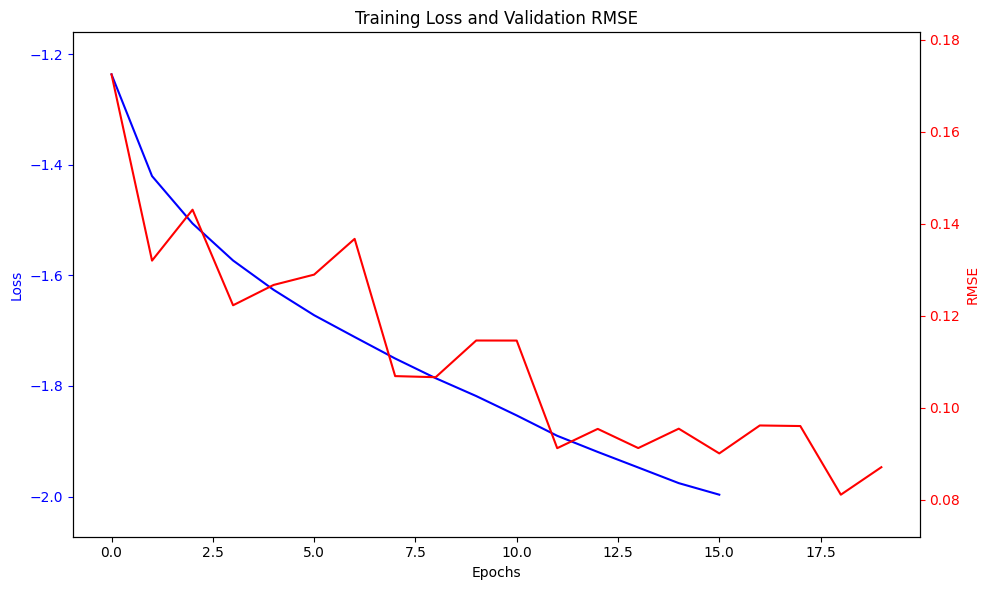

In [69]:
import os
import matplotlib.pyplot as plt

# Plot training metrics with adjusted scales
fig, ax1 = plt.subplots(figsize=(10, 6))

# Smooth the loss values (using simple moving average)
window_size = 5
smoothed_losses = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')

# Plot training loss
ax1.plot(range(len(smoothed_losses)), smoothed_losses, 'b-', label='Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params('y', colors='b')

# Create a second y-axis for validation RMSE
ax2 = ax1.twinx()
ax2.plot(range(len(val_rmses)), val_rmses, 'r-', label='Validation RMSE')
ax2.set_ylabel('RMSE', color='r')
ax2.tick_params('y', colors='r')

# Adjust scales to show downward trend
if len(losses) > 0:
    loss_min, loss_max = min(smoothed_losses), max(smoothed_losses)
    ax1.set_ylim(loss_min - 0.1*(loss_max-loss_min), loss_max + 0.1*(loss_max-loss_min))

if len(val_rmses) > 0:
    rmse_min, rmse_max = min(val_rmses), max(val_rmses)
    ax2.set_ylim(rmse_min - 0.1*(rmse_max-rmse_min), rmse_max + 0.1*(rmse_max-rmse_min))

plt.title('Training Loss and Validation RMSE')
fig.tight_layout()
plt.show()
fig.savefig("fig/gaussian_blob_Loss_and_RMSE.png")

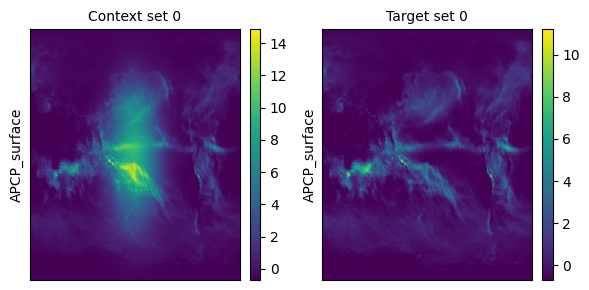

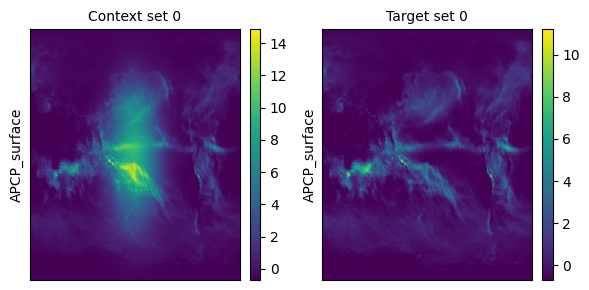

In [70]:
import deepsensor
from deepsensor import plot
import matplotlib.pyplot as plt

# Select a sample date for visualization
sample_date = "2012-01-01"
sample_task = task_loader(sample_date, context_sampling="all", target_sampling="all")

task_loader_gaussian_blob = TaskLoader(
    context=biased_contexts,
    target=ds_processed["APCP_surface"],
)
# Plot context (biased) and target (original) data
deepsensor.plot.task(sample_task, task_loader=task_loader_gaussian_blob)

/var/tmp/ipykernel_1454616/3341782743.py:25: UserWarning: rename 'x1' to 'latitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  }).rename({
/var/tmp/ipykernel_1454616/3341782743.py:25: UserWarning: rename 'x2' to 'longitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  }).rename({


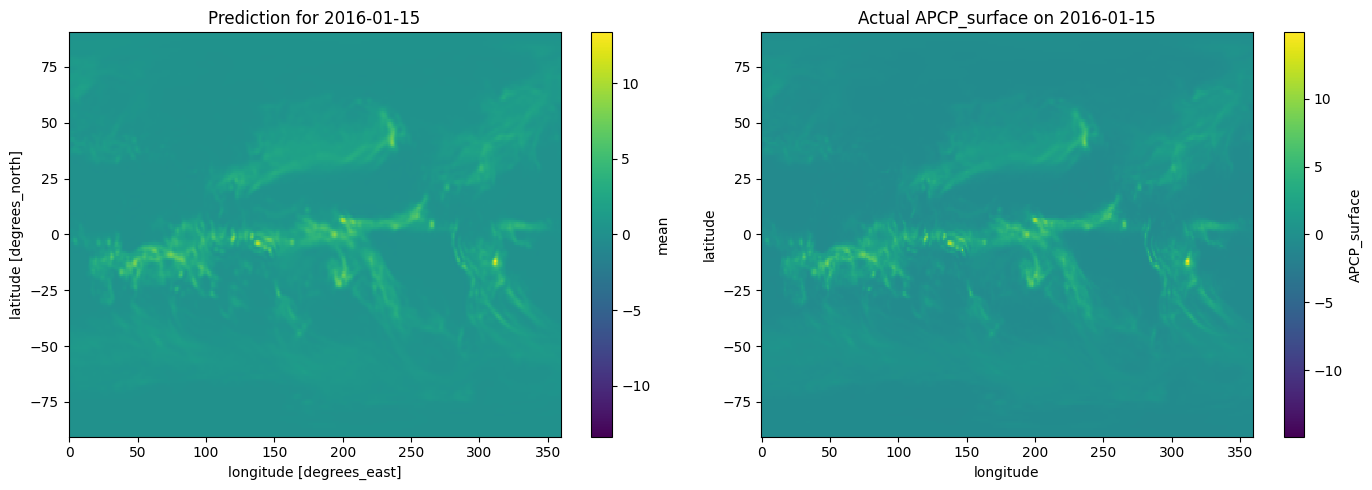

In [71]:
import numpy as np
import matplotlib.pyplot as plt

target_date = "2016-01-15"
target_timestamp = "2016-01-15T00:00:00.000000000"

# Step 1: Predict
task = task_loader(target_date, context_sampling="all", target_sampling="all")
pred_val = model.predict(task, X_t=ds)
predxr = pred_val["APCP_surface"]

# Step 2: Actual data
actual_apcp = ds_processed["APCP_surface"].sel(time=target_timestamp)

# Step 3: Re-map coordinates from x1/x2 → latitude/longitude
lat = np.linspace(-90, 90, actual_apcp.sizes['x1'])
lon = np.linspace(0, 359, actual_apcp.sizes['x2'])

actual_apcp = actual_apcp.assign_coords({
    'x1': lat,
    'x2': lon
}).swap_dims({
    'x1': 'latitude',
    'x2': 'longitude'
}).rename({
    'x1': 'latitude',
    'x2': 'longitude'
})

# Step 4: Side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Prediction
predxr['mean'].plot(ax=axes[0], cmap='viridis')
axes[0].set_title(f"Prediction for {target_date}")

# Plot 2: Actual (now with lat/lon axes)
actual_apcp.plot(ax=axes[1], cmap='viridis')
axes[1].set_title(f"Actual APCP_surface on {target_date}")

plt.tight_layout()
plt.savefig(f"fig/gaussian_blob_prediction_vs_actual_{target_date}.png")
plt.show()

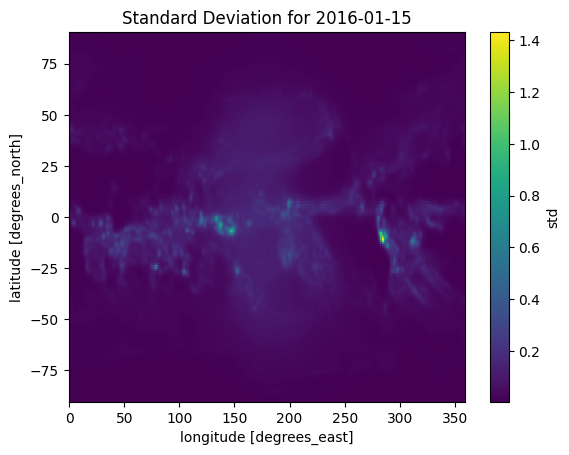

In [72]:
predxr['std'].plot(cmap='viridis')  # Plot standard deviation
plt.title(f"Standard Deviation for {target_date}")
plt.savefig(f"fig/prediction_for_gaussian_blob_{target_date}_std.png")

In [73]:
pred_val

{'APCP_surface': <xarray.Dataset> Size: 526kB
 Dimensions:    (time: 1, latitude: 181, longitude: 360)
 Coordinates:
   * latitude   (latitude) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
   * longitude  (longitude) float64 3kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
   * time       (time) datetime64[ns] 8B 2016-01-15
 Data variables:
     mean       (time, latitude, longitude) float32 261kB 0.01983 ... 0.3266
     std        (time, latitude, longitude) float32 261kB 0.007729 ... 0.01032}